### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml


# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
CustNanoData = {
    # 'BKG'    : "/ospool/cms-user/yuzhe/Tree/V8/2018/Merged/MC/Tree_BKG.root",
    'data'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Data/SlimmedTree_Data.root",
    'QCD'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_QCD.root",          
    'Top'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Top.root",
    'WJets'       : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_WJets.root",
    'Rest'        : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Rest.root",
    'TotalSignal' : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_Total.root",
    'ggF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_GluGlu.root",
    'VH'          : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VH.root",   
    'ttH'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_ttH.root",
    'VBF'         : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VBF.root",
    # 'ST'     : "/ospool/cms-user/yuzhe/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_ST.root",

}
# BKG = set([k for k in CustNanoData.keys() if not (k == "Signal" or k=='data')])
BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })

### Get DPhi in the events

In [3]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data
[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82,

In [4]:
def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.2)),mH_reco, events["Mj_V2_a"])
get_reco(files["QCD"]) 
print("done QCD")
get_reco(files["data"]) 
print("done data")  
get_reco(files["Top"])
get_reco(files["WJets"])
get_reco(files["Rest"])
# get_reco(files["WplusRest"])
print("done bkg") 
get_reco(files["TotalSignal"])
get_reco(files["ggF"])
get_reco(files["VH"])
get_reco(files["ttH"])
get_reco(files["VBF"])
print("done signal") 

done QCD
done data
done bkg
done signal


### some test about variables

In [5]:
files["VBF"]["DPhi"]

<Array [2.97, 2.31, 0.0849, ... 2.01, 2.45] type='17017 * float32'>

### plot setting

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

### prepare prefit QCD distribution for CR and SR respectively

In [6]:
def store_root(file_name, dir_name, hist_name, bin_edges, bin_contents, bin_errors, rewrite = False, verbose = False):
    if os.path.exists(file_name):
        if verbose: print(f"The file '{file_name}' already exists.")
        if not rewrite:
            if verbose:print("Will update it.")
            output_file = ROOT.TFile(file_name, "update")
        else: 
            if verbose:print("Will recreate one.")
            output_file = ROOT.TFile(file_name, "recreate")
    else:
        if verbose:print(f"The file '{file_name}' does not exist, will create a new one")
        output_file = ROOT.TFile(file_name, "recreate")
    if output_file.GetDirectory(dir_name):
        if verbose:print("The " + dir_name + " directory exists in the ROOT file, use the existing one")
        output_file.cd(dir_name)
    else:
        if verbose:print("The " + dir_name + " directory does not exist in the ROOT file, create a new one")
        output_file.mkdir(dir_name)
        output_file.cd(dir_name)
    histogram = ROOT.TH1D(hist_name, "Histogram 1", len(bin_edges) - 1, bin_edges)
    for i, content in enumerate(bin_contents):
        histogram.SetBinContent(i + 1, content)
        histogram.SetBinError(i + 1, bin_errors[i]) 
    histogram.Write()
    output_file.Close()
    

    # Return the updated histogram and variance

#Function that plot mass distribution, with different tagger cut in the same plot.
def plot_mass_shape_store_blinded(files, nbins=20, x_min=40, x_max=240, legend_location='upper left',suffix = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year="Full-Run2", ax=ax, fontname='sans-serif')
    def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
        h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
        if overflow: 
            # h, var also include underflow bins but in plots usually no underflow data
            # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
            # You have to access the overflow and underflow bins data like below:
            h[-2] += h[-1]; var[-2] += var[-1]
        if underflow:
            h[1] += h[0]; var[1] += var[0]
        if overflow or underflow:
            h, var = h[1:-1], var[1:-1]
        return np.array([h, var])
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.975))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8))
        elif SR == "SR3a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.975) & (events["DPhi"] < 0.8)),
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3 ) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        elif SR == "SR3b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["DPhi"] < 0.8) & (events["a_HWW_V2"] >= 0.8) & (events["a_HWW_V2"] < 0.975))
        else: print("invalid SR value")
        return maskdict_sr
    def maskdict_cr(files_i, CR):
        events = files_i
        if   CR == "SR1a" or CR == "SR1b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] < 0.3) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8)), 
        elif CR == "SR2a" or CR == "SR2b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.3) & (events["MET_et"]/events["PTj_V2_a"] <= 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) ),         
        elif CR == "SR3a" or CR == "SR3b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] > 0.6) & (events["a_HWW_V2"] >= 0.6) & (events["a_HWW_V2"] < 0.8) & (events["DPhi"] < 0.8)),
        else: print("invalid CR value")
        return maskdict_cr
    for met in ["SR1","SR2","SR3"]:
    # for met in ["SR1"]:
        #we store just 1 root files 
        rest = ["Top","WJets","Rest"]
        events_rest_tmp = ak.concatenate([files[i] for i in rest], axis=0)
        hist_cr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Data = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Rest = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        events_cr_QCD     = files["QCD"][maskdict_cr(files["QCD"],met + "a")]
        events_cr_Data    = files["data"][maskdict_cr(files["data"],met + "a")]
        events_cr_Rest    = events_rest_tmp[maskdict_cr(events_rest_tmp,met + "a")]
        hist_cr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #only used to calculate CR QCD yields
        hist_cr_Data.fill(events_cr_Data["MH_Reco"],  weight = events_cr_Data["weight"])
        hist_cr_Rest.fill(events_cr_Rest["MH_Reco"],  weight = events_cr_Rest["weight"])
        bins = hist_cr_QCD.axes[0].edges
        yields_cr_QCD = np.sum(flow(hist_cr_QCD)[0]) # to include overflow
        # hist_cr_QCD_value    = flow(hist_cr_QCD)[0] # not used at all 
        hist_cr_Data_value   = flow(hist_cr_Data)[0]
        hist_cr_Rest_value   = flow(hist_cr_Rest)[0] 
        # hist_err_cr_QCD_value    = np.sqrt(flow(hist_cr_QCD)[1]) #not used at all
        hist_err_cr_Data_value   = np.sqrt(flow(hist_cr_Data)[1])
        hist_err_cr_Rest_value   = np.sqrt(flow(hist_cr_Rest)[1])
        # print("hist value and variance done.")                          
        hist_Data_Rest_value = hist_cr_Data_value - hist_cr_Rest_value
        hist_err_Data_Rest_value = np.sqrt((hist_err_cr_Data_value)**2 + (hist_err_cr_Rest_value)**2 )  
        hep.histplot(hist_Data_Rest_value,     bins=bins, yerr=hist_err_Data_Rest_value, label= met.replace("S","C") + " estimated QCD(pre-fit)", lw = 2,edges = False, histtype="step") #,color = "red")
        if met == "SR1" : store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=True)
        else: store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=False)              
        print("finish ", met.replace("S","C"))
        for region in ["a","b"]:
            hist_sr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
            events_cr_QCD     = files["QCD"][maskdict_sr(files["QCD"],met+region)]
            hist_sr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #also only used for SR QCD yields
            yields_sr_QCD = np.sum(flow(hist_sr_QCD)[0]) 
            mc_ratio = yields_sr_QCD/yields_cr_QCD
            hist_value = mc_ratio * hist_Data_Rest_value #means hist value in SR, using mc_ratio * hist_Data_Rest_value in CR QCD
            hist_err_value = mc_ratio * hist_err_Data_Rest_value
            hep.histplot(hist_value,     bins=bins, yerr=hist_err_value, label= met + region + " estimated QCD(pre-ft)", lw = 2,edges = False, histtype="step") #,color = "red")      
            store_root("./root/perfit_QCD.root","QCD",met+ region ,bin_edges = bins, bin_contents = hist_value, bin_errors = hist_err_value, rewrite=False)
            print("finish ",met + region)              
    # plt.ylim(0, 1e9)
    plt.xlabel("Higgs candidate MET-reco. mass", fontsize=20, ha='right', x=1)
    plt.ylabel("Events.", fontsize=20, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1, top = 1e9)
    plt.legend(loc=legend_location,frameon=False,fontsize=12)
    plt.savefig(f"./plots/mass_distri_prefit_QCD_{suffix}.pdf", bbox_inches='tight')
    plt.show()

finish  CR1
finish  SR1a
finish  SR1b
finish  CR2
finish  SR2a
finish  SR2b
finish  CR3
finish  SR3a
finish  SR3b


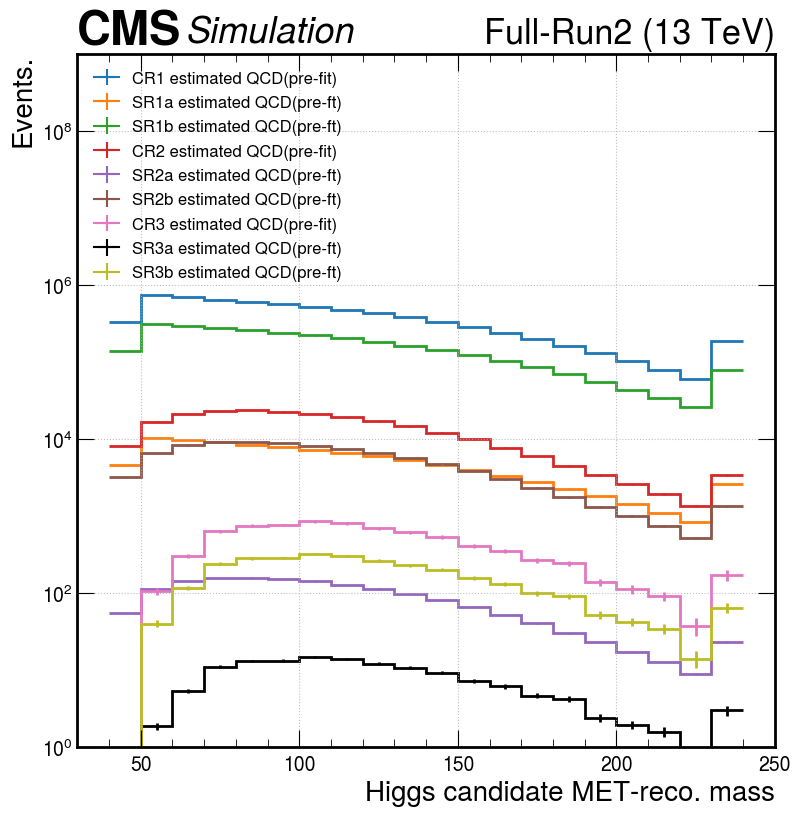

In [27]:
plot_mass_shape_store_blinded(files = files,nbins = 20, x_min=40, x_max=240,suffix = "")

### read the files just stored

In [7]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### Plot variables

In [8]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def prefit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":    # read from root  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b) # todo
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [9]:
CUT = {        
        "SR1a" : {k: ( (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files},
        "SR1b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "SR2a" : {k: ( (files[k]["DPhi"] < 0.8)     & (files[k]["a_HWW_V2"] > 0.975)  & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR2b" : {k: ( (files[k]["a_HWW_V2"] > 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},
        "SR3a" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] > 0.975) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "SR3b" : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.975) & (files[k]["a_HWW_V2"] > 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
        "CR1"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.3)) for k in files}, 
        "CR2"  : {k: ( (files[k]["a_HWW_V2"] > 0.6) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.3) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] < 0.6)) for k in files},       
        "CR3"  : {k: ( (files[k]["DPhi"] < 0.8) & (files[k]["a_HWW_V2"] <= 0.8) & (files[k]["a_HWW_V2"] > 0.6) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] >= 0.6)) for k in files},
    }

In [10]:
def prefit_runPlots(region = "PS", events = files,othertext = "", blind = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, othertext = othertext, plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False)

In [ ]:
prefit_runPlots(region = "SR1a", othertext = "prefit")
prefit_runPlots(region = "SR1b", othertext = "prefit")
prefit_runPlots(region = "CR1",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR2a", othertext = "prefit")
prefit_runPlots(region = "SR2b", othertext = "prefit")
prefit_runPlots(region = "CR2",  othertext = "prefit", blind = False)
prefit_runPlots(region = "SR3a", othertext = "prefit")
prefit_runPlots(region = "SR3b", othertext = "prefit")
prefit_runPlots(region = "CR3",  othertext = "prefit", blind = False)

### Save hist templates to pkl files

In [72]:
def save_pkl(files):
    regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2","SR3a","SR3b","CR3"] #signal regions or control regions
    samples = ['data','QCD','Top','WJets','Rest','TotalSignal','ggF','VH','ttH','VBF']
    weights = [] #uncertainties to be added 
    hists = {}
    bins = {
        "MH_Reco": list(range(40, 250, 10)),
    }
    for region in regions:
        hists[region] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.StrCategory([], name="systematic", growth=True),
            hist2.axis.Variable(bins["MH_Reco"], name="MH_Reco", label=r"Higgs candidate MET recovery mass [GeV]", overflow=True,underflow=True),
        ) #initialize a hist object
        for sample in samples:
            data = files[sample][CUT[region][sample]]
            hists[region].fill(
                samples=sample,
                systematic="nominal",
                MH_Reco=data["MH_Reco"],
                weight=data["weight"],
            )  
            for weight in weights:
                pass #uncertainties to be added
            if sample == "QCD":
                #read from root files  
                hist_value , _ = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
                hists[region]["QCD","nominal",:] = hist_value
                #variance not set from root file
            else:
                #add overflow
                hists[region][sample,"nominal",-1] = hists[region][sample,"nominal",:].view(flow=True)[-1]
        print("done",region)       
    with open(f"./templates/hists_templates.pkl", "wb") as fp:
        pkl.dump(hists, fp) # dump the templates of each region in a pkl file

In [75]:
save_pkl(files = files)

done SR1a
done SR1b
done CR1
done SR2a
done SR2b
done CR2
done SR3a
done SR3b
done CR3


### some test about the output templates

In [90]:
with open("./templates/hists_templates.pkl", "rb") as f:
    hists_templates = pkl.load(f)
hists_templates["SR2b"]["QCD","nominal",:]

Hist(Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Double()) # Sum: 93769.21891586625 (94671.26574156353 with flow)

In [91]:
hists_templates["SR3a"].project("MH_Reco") #N.B. here data is also added

Hist(Variable([40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], name='MH_Reco', label='Higgs candidate MET recovery mass [GeV]'), storage=Double()) # Sum: 1284.0328060902589 (1391.2353290328374 with flow)

### Some other implementation

In [34]:
# Here we put all the predicted shape root files in a dict to be used in the last function
filesname = {
      # "SR1a" : "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root",
      # "SR1b" : "/home/pku/zhaoyz/Higgs/MDStudy/SR1b_Shape.root",
      # "SR2a" : "/home/pku/zhaoyz/Higgs/MDStudy/SR2a_Shape.root",
      # "SR2b" : "/home/pku/zhaoyz/Higgs/MDStudy/SR2b_Shape.root",
      # "SR3a" : "/home/pku/zhaoyz/Higgs/MDStudy/SR3a_Shape.root",
      # "SR3b" : "/home/pku/zhaoyz/Higgs/MDStudy/SR3b_Shape.root",
     
      "SR1a" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR1a2sidebandblinded_Shape.root",
      "SR1b" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR1b2sidebandblinded_Shape.root",
      "SR2a" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR2a2sidebandblinded_Shape.root",
      "SR2b" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR2b2sidebandblinded_Shape.root",
      "SR3a" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR3a2sidebandblinded_Shape.root",
      "SR3b" : "/home/pku/zhaoyz/Higgs/MDStudy/Inclusive/SR3b2sidebandblinded_Shape.root",
}
RP1 = {
    "SR1a": {
        "QCD" : 0.51,
        "Top" : 2.4,
        "WJets":4.0,
        "Rest" :4.0,
    },
    "SR1b": {
        "QCD" : 1.09,
        "Top" : 0.1,
        "WJets":4.0,
        "Rest" :4.0,
    },
    "SR2a": {
        "QCD" : 1.2,
        "Top" : 1.7,
        "WJets":0.1,
        "Rest" :0.1,
    },
        "SR2b": {
        "QCD" : 0.96,
        "Top" : 1,
        "WJets":4.0,
        "Rest" :4.0,
    },
        "SR3a": {
        "QCD" : 4,
        "Top" : 0.6,
        "WJets":2.1,
        "Rest" :2.1,
    },
        "SR3b": {
        "QCD" : 2.9,
        "Top" : 1.9,
        "WJets":0.6,
        "Rest" :0.6,
    }
}
RP = {
    "SR1a": {
        "QCD" : 0.895,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    },
    "SR1b": {
        "QCD" : 1.328,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    },
    "SR2a": {
        "QCD" : 0.895,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    },
        "SR2b": {
        "QCD" : 1.328,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    },
        "SR3a": {
        "QCD" : 0.895,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    },
        "SR3b": {
        "QCD" : 1.328,
        "Top" : 1,
        "WJets":1,
        "Rest" :1,
    }
}

TF = {
    "VR1":{
        "QCD":np.array([0. ,        0.   ,      0.     ,    0.     ,    1.65809737, 1.48696671,
 1.44472739 ,1.40645643 ,1.36931404, 1.32935847, 1.29511225, 1.26526127,
 1.25687254 ,1.23328001 ,1.22750304, 1.21843436, 1.2041198 , 1.23302888,
 1.22618161 ,1.20481248 ,1.22021658, 1.20793022, 1.21858557, 1.20855105,
 1.22599041]),

#         "QCD"  : np.array([0,         0,        0,         0,         1.63293709, 1.46440343,
#  1.42280886 ,1.38512409, 1.34855178, 1.3092086  ,1.27548771 ,1.24609869,
#  1.23785687 ,1.21463292, 1.20891825, 1.19996468 ,1.18585898 ,1.21432919,
#  1.20758673 ,1.18654194, 1.2017137 , 1.18961392 ,1.20010901 ,1.19022557,
#  1.20740413]),



        "Top"  :
        np.array([  0. ,          0.  ,          0.  ,          0.  ,        189.94748626,
  248.11151059, 167.05917941 ,  78.67982625 ,  41.50023982 ,  42.8098616,
  50.08497224 , 43.87635007  , 37.79582758  , 30.40703421  , 25.1691246,
  19.30578809 , 13.49182963  , 11.3894762   ,  9.96000343  , 10.14094684,
  12.91728014 , 14.15774968  , 15.50055443  , 14.87261799  , 16.30859652        ]),
        "WJets":
        np.array([ 0. ,         0. ,         0. ,         0.,        64.3917948 , 59.52247568,
 46.78250294 ,27.39563036 ,16.69940159 ,18.14936666,21.46217364        , 19.03567881,
 15.82663318 ,12.75195976 ,11.3080681  ,10.05060799, 8.97076777        , 9.51552763,
  9.06627118 , 8.06806032 , 8.47381586 , 7.94412562, 8.54825167        , 8.23354536,
  8.65978365]),
        "Rest" :
        np.array([  0. ,          0.,           0.  ,         0. ,        147.95618362,
 151.32477597          ,130.44238922, 105.67673412  ,68.39249682 , 43.9841655,
  41.87546619          , 48.81703753,  48.44693608  ,38.80677026 , 32.29587402,
  27.97233329          , 23.82188065,  25.43086899  ,22.54332028 , 19.9395509,
  20.15687328          , 18.63337434,  19.82685599  ,18.48168249 , 20.52709233]),
    },
    "VR2" : {
       "QCD": np.array([0.    ,     0.       ,  0.      ,   0.  ,       1.81162319, 1.5910162,
 1.51029656 ,1.47070474 ,1.4295999  ,1.38641807, 1.31034002 ,1.2783571 ,
 1.18997208 ,1.2767548  ,1.31839401 ,1.29818233, 1.29456334 ,1.33058052,
 1.18824698 ,1.12291478 ,1.20576519 ,1.52259963, 1.30370732 ,1.64458026,
 1.12397817]),

#         "QCD"  : np.array([0.     ,    0.     ,    0.   ,      0.  ,       1.78758877 ,1.56990381,
#  1.49026772, 1.45122254 ,1.41067874, 1.36810853, 1.29305132 ,1.26150127,
#  1.17430175, 1.25993718 ,1.30101008, 1.28106677, 1.27750819 ,1.31306356,
#  1.1726445 , 1.10822595 ,1.18999021, 1.50267824, 1.28655415 ,1.62301638,
#  1.1093481 ]),



        "Top"  :np.array([ 0.  ,        0.     ,     0.   ,       0.     ,    47.5233095 , 53.92435498,
 35.51214525 ,22.25580811, 14.83998334, 13.17077334 ,11.48496347,  9.54072182,
  5.82866129 , 6.43222274,  5.85389016,  4.71757591 , 4.05037024,  3.49246998,
  2.20000253 , 1.70428388,  2.32112656,  4.49487829 , 3.52660868,  5.61983049,
  2.09268892]),
        "WJets":np.array([ 0.      ,    0.      ,   0.   ,       0.  ,       40.61173091 ,32.6188603,
 23.43783365 ,17.94355337 ,15.87078866, 15.01636846, 12.78667889, 11.53322321,
  7.55712045 , 9.74129749 , 9.79769813,  8.48133995,  7.91693692,  8.48093305,
  5.30919873 , 3.4906291  , 5.07135979, 10.33111999,  6.71634689, 12.01443181,
  3.12094328]),
        "Rest" : np.array([ 0.       ,   0.     ,     0.     ,     0.      ,   84.81826425 ,74.69392274,
 59.93134419, 47.68992641, 41.04371219, 34.21749808 ,25.72965624, 25.40973467,
 16.26545374, 20.40104089, 18.6089611 , 17.00494098 ,12.9057827 , 15.3058375,
  9.00336116,  5.58331806,  8.46429658, 13.34129061 , 9.98560078, 15.06254018,
  4.13888041])

    },
    "VR3" : {

       "QCD":np.array([0.        , 0.,         0.,         0.,         2.44423411, 1.89235245,
 1.83149993 ,2.10640704, 1.97013881 ,1.8922337 , 1.66257261, 1.45174958,
 1.82981458 ,2.22452386, 3.24061113 ,2.82356927, 2.48616005, 3.1119041,
1.71297751 ,1.38205261, 0.86092817 ,4.18138468, 4.66311532, 7.48736527,
 4.74540551]),

#        "QCD"   : np.array([0.      ,   0.      ,   0.   ,      0.     ,    2.25949689 ,1.74933266,
#  1.6932367  ,1.94754081, 1.82176022, 1.74988571, 1.53769719, 1.34276699,
#  1.69265431 ,2.05744205, 2.99854541, 2.61108942, 2.3000258 , 2.87716989,
#  1.58489393 ,1.27831425, 0.79747192, 3.86945198, 4.31613249, 6.92154906,
#  4.39010794]),



        "Top"  :np.array([0.       ,  0.       ,  0.    ,     0.   ,      8.30103538, 8.29025664,
 6.4841457 ,6.3744761 , 4.46969044, 3.80728571 ,3.03243862, 2.19620161,
 2.62614344,3.22840243, 3.109635  , 3.14119074 ,2.27637445, 2.22481988,
 1.68330008,1.34784268, 0.67954307, 2.85123198 ,1.93313566, 2.91874321,
 2.51699504]),
        "WJets":np.array([ 0.    ,      0.   ,       0.      ,    0. ,        10.30969773 , 6.75177476,
  5.90779998 , 7.37407367,  6.62075081,  6.05148591,  4.68957742,  3.32846868,
  4.56830745 , 5.62101833,  5.70393104,  6.87127318,  4.67086075,  6.37821304,
  4.09171642 , 2.30737355, -0.01696281,  7.93062536,  3.04139725,  5.91873835,
  4.60105486]),
        "Rest" :np.array([ 0.     ,     0.      ,    0.   ,       0.,         21.11179009 ,13.9321699,
 11.15240376, 16.24007553, 14.03820243, 11.29464973 , 7.71789274,  4.68390115,
  5.6847128 ,  6.69480472,  6.3528591 ,  6.50144795 , 5.44910843,  5.59918255,
  3.86359899,  2.14271906,  0.04600002,  5.46732222 , 3.07784832,  3.74472602,
  3.36576488])

    },
    

    #10 bins -->  20bins
#     "SR1a" : {
#         "QCD":np.repeat(np.array([1.02174089, 0.93867556, 0.88923293 ,0.8435651 ,0.81692045, 0.80240031,
#  0.79427321 ,0.79731313, 0.7989176 , 0.79187206]),2)
#     },
#     "SR2a" : {
#         "QCD":np.repeat(np.array([0.96874364, 0.87545579 ,0.89115041, 0.87220254, 0.87876115, 0.88824668,
#  0.97637868, 1.02302823, 1.06244447, 1.13963372]),2)
#     },
#     "SR3a" : {
#         "QCD":np.repeat(np.array([2.49184115 ,1.87568898 ,1.72469414 ,1.99347801, 2.35355035 ,1.81220675,
#  1.72707268, 2.71687688 ,2.98854509 ,3.25439914]),2)
#     },
#     "SR1b" : { 
#         "QCD":np.repeat(np.array([1.47868913, 1.36003436, 1.29032424, 1.22392361 ,1.18730593 ,1.16739625,
#  1.15919618 ,1.16139016, 1.15930872 ,1.15476954]),2)
#     },
#     "SR2b" : {
#         "QCD":np.repeat(np.array([1.79281694, 1.45649389 ,1.3952214 , 1.29926631 ,1.27170644 ,1.270774,
#  1.33912032 ,1.30781495, 1.31748609 ,1.36984224]),2)
#     },
#     "SR3b" : {
#         "QCD":np.repeat(np.array([1.76678411 ,1.32991523 ,1.22285572 ,1.4134309 , 1.66873212 ,1.28490457,
#  1.22454217 ,1.92634066 ,2.11896091 ,2.30745876]),2)
#     },
    

    #20bins
       "SR1a": {
           "QCD":np.array([1.09825406, 0.98590385, 0.948792  , 0.92138404, 0.90030586 ,0.87388426,
 0.84978668, 0.83624358 ,0.82824128 ,0.80756581 ,0.80555782, 0.80179424,
 0.79200928, 0.80475555, 0.8026009 , 0.79386169, 0.80220614 ,0.79473294,
 0.7943369 , 0.79589215])
       },
       "SR2a" : {
           "QCD":np.array([1.30401403, 1.03210506, 0.92473019, 0.9774468  ,0.99671633 ,0.9506645,
 0.9532403 , 0.94644526, 0.96742661 ,0.91552859, 0.92150116, 0.9543077,
 0.96867375, 0.93659694, 1.00948361 ,0.96868389, 0.97714142, 1.0040717,
 1.00606915, 0.9864919 ]),
       },
       "SR3a" : {
           "QCD":np.array([0.   ,      2.92243851 ,2.25832463, 2.17263814 ,2.01537372 ,2.02992636,
 2.07262215 ,2.70515449 ,2.97896856, 2.5471852 , 1.88656568 ,2.54645009,
 2.32333584, 1.48660057, 3.53429835 ,2.85364614, 4.98635081, 3.51785623,
 1.97156585 ,5.70740629]),
       },
       "SR1b" : {
           "QCD":np.array([1.59834404, 1.43483516, 1.38082444, 1.34093627,1.31026013, 1.27180745,
 1.23673704, 1.2170271 ,1.20538094   , 1.1752909 , 1.17236857, 1.16689124,
 1.15265071, 1.17120099,1.16806522   , 1.1553466 , 1.16749071, 1.15661459,
 1.15603821, 1.15830164]),
       },
       "SR2b" : {
           "QCD":np.array([1.96771096, 1.72917839 ,1.46021539 ,1.4692539  ,1.4519157 , 1.36773886,
 1.31800769 ,1.29560763,     1.28679695, 1.2187317  ,1.23440569 ,1.27627129,
 1.29568002 ,1.25385828,     1.28992965, 1.23769678 ,1.26578142 ,1.32026444,
 1.35710832 ,1.35070694,]),
       },
       "SR3b" : {
           "QCD":np.array([0.     ,    2.1157659 , 1.63496553 ,1.57293085, 1.45907569 ,1.46961141,
 1.500522   ,1.95845819 ,2.15669212, 1.84409273 ,1.36582218 ,1.84356053,
 1.68203188 ,1.07625834 ,2.55873576, 2.0659621 , 3.60998221 ,2.54683212,
 1.42735999 ,4.13200674]),
       },

    }



### plot postfit results

In [ ]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def postfit_plot(arrays,weight, plot_name: str, x_name: str, region = 'PS',applyTF = False, TF = None, cuts=None,othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, applyRP = False, RP = None, nametext = ""):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        #cuts not used here.
    if blind:
        mask = np.logical_or(arrays["data"] <= 80, arrays["data"] >= 160)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]
        # arrays["data"] = arrays["data"][arrays["data"] <= 80 or arrays["data"] > 160]    
    
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
    
    ## analyze
    # Means BKG should be plotted with stack plot
    # Data and Signal should be plotted with stack plot
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
            # Not used here
        # Fill the empty value with -999
        values = ak.fill_none(v, -999)
        if k!='data':
            # hist.fill(values, weight=np.abs(weight[k]))
            # Then should add the weight for each events
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        # Now h & var is already the histgram and variance of some samples like QCD, TotalSignal...
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            # stacked['h'][k] = h
            # stacked['var'][k] = var
            # for prediction:
            if k == "QCD" :
                    # actually here the "applyTF" is apply predicted QCD shape
                    # stacked['h'][k] = h * TF[region][k]
                    # stacked['var'][k] = var * TF[region][k]
                    stacked['h'][k] , stacked['var'][k]  = read_root(filename = filesname[region], dir = region, name = "QCD")
                    if applyRP == True:
                        stacked['h'][k] , stacked['var'][k] = stacked['h'][k]*RP[region][k] , stacked['var'][k]*((RP[region][k])**2)
            else:
                stacked['h'][k] = h
                stacked['var'][k] = var
                if applyRP == True:
                    stacked['h'][k] , stacked['var'][k] = stacked['h'][k]*RP[region][k] , stacked['var'][k]*((RP[region][k])**2)
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    ## plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        # BKG_list = ["QCD","Top","WJets","Rest"]
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        # print("err list:",err_list)
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["red", "green", "orange","blue"]
        # colors = ["#d62728", "#2ca02c", "#ff7f0e","#1f77b4"]
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        # order = [3,2,1,0]
        # for i in order:
        #     h = h_list[i]
        #     label = label_list[i]
        #     hep.histplot(h, bins=hist.axes[0].edges, label=label, histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        # print("err:",bkg_err)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        # We considered the error of MC bkg    
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001);
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        # either signal of data
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            # hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            # print(k, h)
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            # print("bins:",hist.axes[0].edges)
            if k == "TotalSignal":
                # pass
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal cut =",best_lower, best_upper, best_s_sqrt_b)
    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    if log:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*(1e3 if not density else 1.2))
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    # plt.text(0.1, 0.85,r"$Signal\times$"+str(NORM_s1),fontsize=15, color="black", ha='left',transform=ax.transAxes)
    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}update_0905.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
def postfit_runPlots(region = "PS", events = files,othertext = "", applyTF = False, met_reco = False):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}
    if met_reco == True:
        for k in events:
            print("Add MET reco of:",k)
            get_reco(events=events[k])        
    # data_mc_compare_plot(arrays = {k: events[k][CUT[region][k]]["a_HWW_V2"] for k in events},  region = region ,applyTF = applyTF, TF = TF,othertext = othertext,plot_name='HWWvsAlla', x_name=r'$jet_{a}:HWWvsAll$', x_max=1, x_min=0, bins=40, weight =weight, year="Full-Run2")
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region ,applyTF = applyTF, TF = TF,othertext = othertext,plot_name='METReco', x_name=r'$jet_{a}:MET Reco. Mass$', x_max=240, x_min=40, bins=20, weight =weight, year="Full-Run2",blind = True, blindMC = True, applyRP = True, RP = RP)
    # data_mc_compare_plot(arrays = {k: events[k][CUT[region][k]]["DPhi"] for k in events},  region = region ,applyTF = applyTF, TF = TF,othertext = othertext,plot_name='DPhi', x_name=r'$jet_{a}:DPhi(H,MET) $', x_max=3.2, x_min=0, bins=32, weight =weight, year="Full-Run2")
    # data_mc_compare_plot(arrays = {k: events[k][CUT[region][k]]["Mj_V2_a"] for k in events},  region = region ,applyTF = applyTF, TF = TF,othertext = othertext,plot_name='Mja', x_name=r'$Mj_{a}(GeV)$', x_max=250, x_min=0, bins=25, weight =weight, year="Full-Run2")
    # data_mc_compare_plot(arrays = {k: events[k][CUT[region][k]]["PTj_V2_a"] for k in events}, region = region ,plot_name='PTja', x_name=r'$pTj_{a}(GeV)$', x_max=1000, x_min=0, bins=25, weight =weight, year="Full-Run2")

In [ ]:
postfit_runPlots(region = "SR1a", met_reco=True, othertext = "PostfitQCDOnly")
postfit_runPlots(region = "SR1b", met_reco=True, othertext = "PostfitQCDOnly")
postfit_runPlots(region = "SR2a", met_reco=True, othertext = "PostfitQCDOnly")
postfit_runPlots(region = "SR2b", met_reco=True, othertext = "PostfitQCDOnly")
postfit_runPlots(region = "SR3a", met_reco=True, othertext = "PostfitQCDOnly")
postfit_runPlots(region = "SR3b", met_reco=True, othertext = "PostfitQCDOnly")

### some other test